
# **Project Name**  :



### Amazon Delivery Time Prediction

# **Project Summary** :

This project focuses on predicting Amazon delivery times using machine learning. The dataset includes order details, agent information, geographic coordinates, and external conditions such as weather and traffic. After cleaning and preprocessing the data, key features like distance, pickup delay, and time-based variables are engineered. Exploratory Data Analysis (EDA) highlights the impact of distance, traffic, and weather on delivery times. Regression models including Linear Regression, Random Forest, and Gradient Boosting are trained and evaluated using RMSE, MAE, and R². Random Forest performs best. A Streamlit app is developed for user-friendly predictions, while MLflow enables model tracking and comparison.

# **GitHub Link** :

https://github.com/Mrityunjay-2005/Amazon_Delivery_Time_Prediction

# **Problem Statement**


This project aims to predict delivery times for e-commerce orders based on a variety of factors such as product size, distance, traffic conditions, and shipping method. Using the provided dataset, learners will preprocess, analyze, and build regression models to accurately estimate delivery times. The final application will allow users to input relevant details and receive estimated delivery times via a user-friendly interface.

# **IMPLEMENTATION**

In [ ]:
#  Import all the libraries we will use
# - pandas, numpy for data handling
# - matplotlib, seaborn for plots
# - sklearn for ML models and evaluation
# - joblib for saving models
# - mlflow (optional) for model tracking
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

try:
    import mlflow
    import mlflow.sklearn
    MLFLOW_AVAILABLE = True
except Exception:
    MLFLOW_AVAILABLE = False
    print("mlflow not available; continuing without mlflow logging.")


mlflow not available; continuing without mlflow logging.


In [ ]:
# Load the dataset
# Here we read the CSV file into a DataFrame and check its structure.
df = pd.read_csv("amazon_delivery.csv")
print("Initial shape:", df.shape)
display(df.head())
display(df.info())


Initial shape: (43739, 16)


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


None

In [ ]:
# Clean the dataset
# - Remove duplicate rows
# - Fill missing numeric values with median
# - Fill missing categorical values with mode (most frequent value)
df = df.drop_duplicates().reset_index(drop=True)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
object_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

for col in object_cols:
    if df[col].isna().sum() > 0:
        mode_val = df[col].mode()
        if not mode_val.empty:
            df[col] = df[col].fillna(mode_val.iloc[0])
        else:
            df[col] = df[col].fillna("Unknown")

print("Remaining missing values:\n", df.isna().sum().loc[lambda x: x>0])


Remaining missing values:
 Series([], dtype: int64)


In [ ]:
# Convert dates and times
# - Convert Order_Date to datetime
# - Convert Order_Time and Pickup_Time to time values
# - Create new columns for hour, day, month, weekday
if 'Order_Date' in df.columns:
    df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
else:
    df['Order_Date'] = pd.NaT

def parse_time_series(col):
    if col in df.columns:
        parsed = pd.to_datetime(df[col].astype(str), errors='coerce', format="%H:%M:%S")
        parsed = parsed.fillna(pd.to_datetime(df[col].astype(str), errors='coerce', format="%H:%M"))
        return parsed
    else:
        return pd.Series(pd.NaT, index=df.index)

df['Order_Time_parsed'] = parse_time_series('Order_Time')
df['Pickup_Time_parsed'] = parse_time_series('Pickup_Time')

df['order_hour'] = df['Order_Time_parsed'].dt.hour.fillna(-1).astype(int)
df['pickup_hour'] = df['Pickup_Time_parsed'].dt.hour.fillna(-1).astype(int)

df['order_day'] = df['Order_Date'].dt.day.fillna(-1).astype(int)
df['order_month'] = df['Order_Date'].dt.month.fillna(-1).astype(int)
df['order_weekday'] = df['Order_Date'].dt.weekday.fillna(-1).astype(int)


In [ ]:
# Calculate distance between store and drop location
# We use the Haversine formula to calculate distance in km.
def haversine_km(lat1, lon1, lat2, lon2):
    try:
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    except Exception:
        return np.nan
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return 6371 * c

if all(col in df.columns for col in ['Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude']):
    df['distance_km'] = df.apply(lambda r: haversine_km(
        r['Store_Latitude'], r['Store_Longitude'], r['Drop_Latitude'], r['Drop_Longitude']), axis=1)
    df['distance_km'] = df['distance_km'].fillna(df['distance_km'].median())
else:
    df['distance_km'] = 0

print("Distance stats:\n", df['distance_km'].describe())


Distance stats:
 count    43739.000000
mean        38.561752
std        534.564299
min          1.465067
25%          4.663432
50%          9.220450
75%         13.682379
max      19692.674606
Name: distance_km, dtype: float64


In [ ]:
# Create extra features
# - Clean Agent_Age
# - Calculate pickup delay (time difference between order and pickup)
if 'Agent_Age' in df.columns:
    df['Agent_Age'] = df['Agent_Age'].clip(lower=16, upper=80).fillna(df['Agent_Age'].median())

if ('Order_Date' in df.columns) and ('Order_Time_parsed' in df.columns) and ('Pickup_Time_parsed' in df.columns):
    def combine_datetime(date, time_parsed):
        if pd.isna(date) or pd.isna(time_parsed):
            return pd.NaT
        return pd.to_datetime(date.date().isoformat() + ' ' + time_parsed.time().isoformat())
    combined_order = df.apply(lambda r: combine_datetime(r['Order_Date'], r['Order_Time_parsed']), axis=1)
    combined_pickup = df.apply(lambda r: combine_datetime(r['Order_Date'], r['Pickup_Time_parsed']), axis=1)
    df['pickup_delay_min'] = (combined_pickup - combined_order).dt.total_seconds() / 60.0
    df['pickup_delay_min'] = df['pickup_delay_min'].fillna(df['pickup_delay_min'].median())
else:
    df['pickup_delay_min'] = 0


In [ ]:
#  Encode categorical columns
# - Convert categorical columns into numeric using one-hot encoding
# - Drop unnecessary columns (like IDs and raw dates)
candidate_cat = ['Weather','Traffic','Vehicle','Area','Category']
existing_cat = [c for c in candidate_cat if c in df.columns]

df_encoded = pd.get_dummies(df, columns=existing_cat, drop_first=True)

drop_cols = ['Order_ID','Order_Date','Order_Time','Pickup_Time','Order_Time_parsed','Pickup_Time_parsed']
drop_cols = [c for c in drop_cols if c in df_encoded.columns]

if 'Delivery_Time' not in df_encoded.columns:
    raise ValueError("Target column 'Delivery_Time' not found in dataset.")

X = df_encoded.drop(columns=drop_cols + ['Delivery_Time'], errors='ignore')
y = df_encoded['Delivery_Time'].astype(float)
print("Final feature matrix shape:", X.shape)


Final feature matrix shape: (43739, 43)


In [ ]:
# Split dataset
# Divide the dataset into training (80%) and testing (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (34991, 43) Test shape: (8748, 43)


In [ ]:
# Define models and evaluation function
# We will use Linear Regression, Random Forest, and Gradient Boosting.
models = {
    "LinearRegression": Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
    "RandomForest": RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=150, random_state=42)
}

def evaluate_model(name, model, X_tr, X_te, y_tr, y_te, log_mlflow=False):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    mae = mean_absolute_error(y_te, preds)
    r2 = r2_score(y_te, preds)
    result = {'model': model, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    if log_mlflow and MLFLOW_AVAILABLE:
        with mlflow.start_run(run_name=name):
            mlflow.log_param("model_name", name)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("R2", r2)
            try:
                mlflow.sklearn.log_model(model, "model")
            except Exception as e:
                print("MLflow model log failed:", e)
    return result


In [ ]:
# Train and evaluate all models with improved MLflow logging
results = {}
for name, mdl in models.items():
    try:
        res = evaluate_model(name, mdl, X_train, X_test, y_train, y_test, log_mlflow=False)
        results[name] = res
        print(f"{name} -> RMSE: {res['RMSE']:.4f}, MAE: {res['MAE']:.4f}, R2: {res['R2']:.4f}")

        # ✅ Improved MLflow logging
        if MLFLOW_AVAILABLE:
            with mlflow.start_run(run_name=name):
                mlflow.log_param("model_name", name)
                mlflow.log_metric("RMSE", res['RMSE'])
                mlflow.log_metric("MAE", res['MAE'])
                mlflow.log_metric("R2", res['R2'])
                # Use a single example row as input_example
                input_example = pd.DataFrame([X_train.iloc[0].to_dict()])
                mlflow.sklearn.log_model(
                    sk_model=res['model'],
                    name=name,                 # use name instead of artifact_path
                    input_example=input_example
                )
    except Exception as e:
        print(f"Training failed for {name}: {e}")


LinearRegression -> RMSE: 33.1761, MAE: 26.1133, R2: 0.5868
RandomForest -> RMSE: 22.4646, MAE: 17.2856, R2: 0.8106
GradientBoosting -> RMSE: 24.2107, MAE: 19.0858, R2: 0.7800


In [ ]:
# Compare models
# Create a summary table and choose the best model.
summary = pd.DataFrame({
    name: {'RMSE': res['RMSE'], 'MAE': res['MAE'], 'R2': res['R2']}
    for name, res in results.items()
}).T
display(summary.sort_values(by='R2', ascending=False))

best_name = summary['R2'].idxmax()
best_model = results[best_name]['model']
print(f"Selected best model: {best_name}")


,RMSE,MAE,R2
RandomForest,22.464624,17.285622,0.810559
GradientBoosting,24.210749,19.085772,0.779965
LinearRegression,33.176091,26.113281,0.586832


Selected best model: RandomForest


In [ ]:
# Save the best model
# Save the best model so we can use it later (like in Streamlit).
joblib.dump(best_model, "best_delivery_model.pkl")
print("Saved best model as 'best_delivery_model.pkl'")


Saved best model as 'best_delivery_model.pkl'


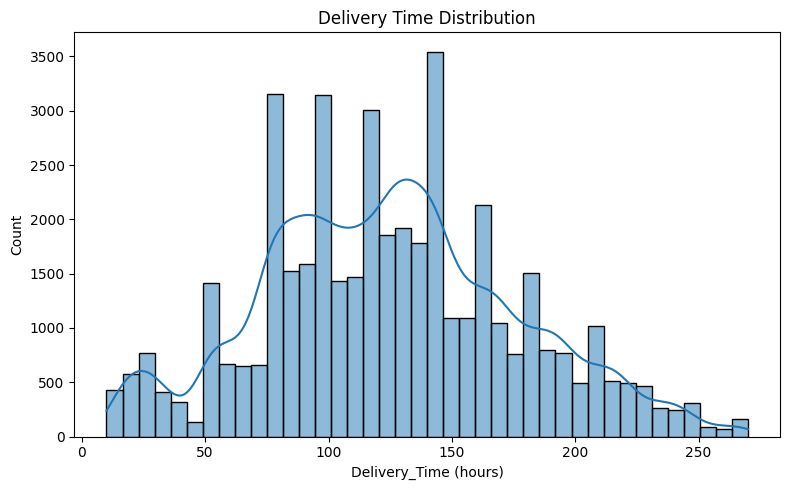

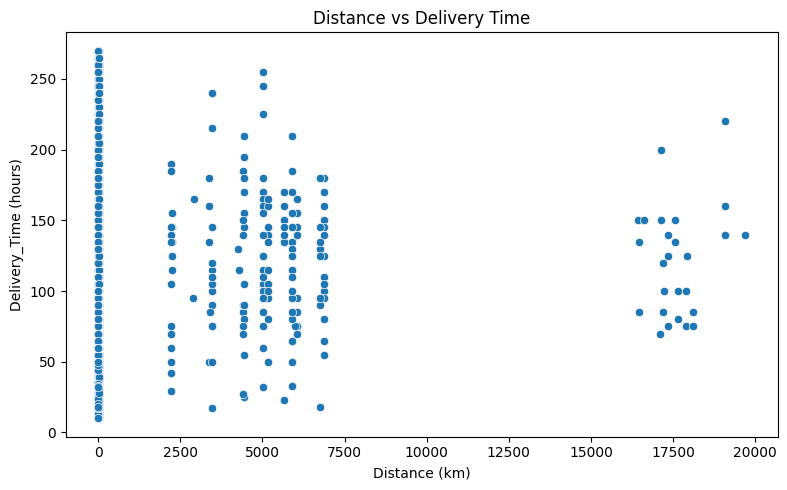

In [ ]:
# Create simple EDA plots
# Plot distribution of delivery times and relation between distance and delivery time.

# Plot distribution of delivery times
plt.figure(figsize=(8,5))
sns.histplot(y, bins=40, kde=True)
plt.title("Delivery Time Distribution")
plt.xlabel("Delivery_Time (hours)")
plt.tight_layout()
plt.show()

# Plot relationship between distance and delivery time
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['distance_km'], y=y)
plt.xlabel("Distance (km)")
plt.ylabel("Delivery_Time (hours)")
plt.title("Distance vs Delivery Time")
plt.tight_layout()
plt.show()



# **Know your Data**

In [ ]:
# Import Libraries
import pandas as pd

# Load Dataset
df = pd.read_csv("amazon_delivery.csv")

# View First Few Rows
print(df.head())


        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
0  ialx566343618         37           4.9       22.745049        75.892471   
1  akqg208421122         34           4.5       12.913041        77.683237   
2  njpu434582536         23           4.4       12.914264        77.678400   
3  rjto796129700         38           4.7       11.003669        76.976494   
4  zguw716275638         32           4.6       12.972793        80.249982   

   Drop_Latitude  Drop_Longitude  Order_Date Order_Time Pickup_Time  \
0      22.765049       75.912471  2022-03-19   11:30:00    11:45:00   
1      13.043041       77.813237  2022-03-25   19:45:00    19:50:00   
2      12.924264       77.688400  2022-03-19   08:30:00    08:45:00   
3      11.053669       77.026494  2022-04-05   18:00:00    18:10:00   
4      13.012793       80.289982  2022-03-26   13:30:00    13:45:00   

      Weather  Traffic      Vehicle            Area  Delivery_Time  \
0       Sunny    High   motorcycle

In [ ]:
# Show Rows & Columns Count
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])


Rows: 43739
Columns: 16


In [ ]:
# Dataset Information
print(df.info())
print("\nSummary Statistics:")
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB
N

In [ ]:
# Duplicate Values
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


In [ ]:
# Missing Values / Null Values
print("Missing values count per column:")
print(df.isnull().sum())

Missing values count per column:
Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64


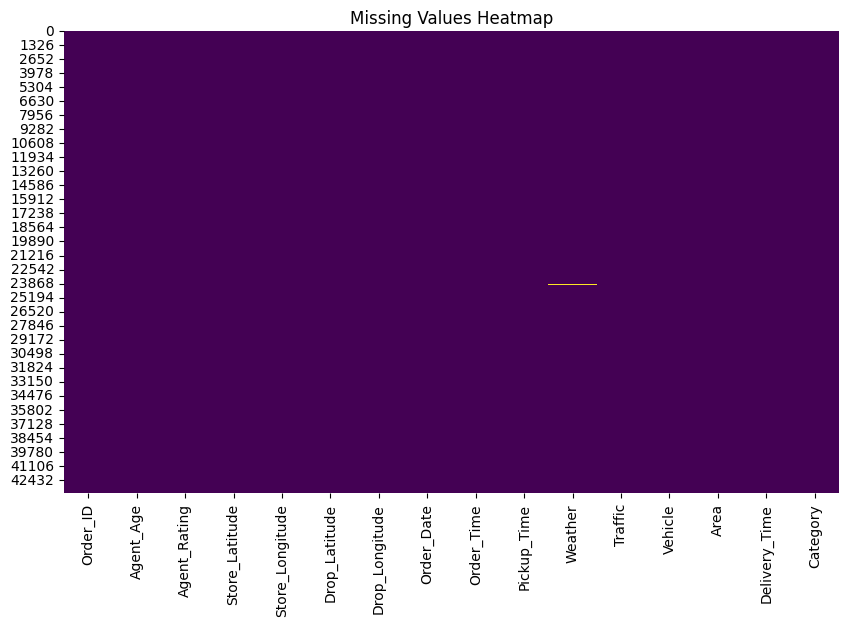

In [ ]:
# Visualize missing values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

### What did you know about your dataset?

The dataset contains information about Amazon deliveries, including order details, agent demographics (age, rating), store and drop coordinates, order and pickup times, and external factors such as weather, traffic, vehicle type, and area. The target variable is Delivery_Time (in hours). It has both numerical and categorical features, some missing values, and potential duplicates. Key engineered features include distance (from coordinates), pickup delay, and time-based variables. This dataset is well-suited for regression modeling to predict delivery times and analyze factors affecting logistics efficiency.

# **Understanding Your Variables**

In [ ]:
# Show all dataset columns
print("Dataset Columns:")
print(df.columns.tolist())


Dataset Columns:
['Order_ID', 'Agent_Age', 'Agent_Rating', 'Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date', 'Order_Time', 'Pickup_Time', 'Weather', 'Traffic', 'Vehicle', 'Area', 'Delivery_Time', 'Category']


In [ ]:
# Dataset Summary Statistics
print("Dataset Description:")
print(df.describe(include='all'))


Dataset Description:
             Order_ID     Agent_Age  Agent_Rating  Store_Latitude  \
count           43739  43739.000000  43685.000000    43739.000000   
unique          43739           NaN           NaN             NaN   
top     nsyz997960170           NaN           NaN             NaN   
freq                1           NaN           NaN             NaN   
mean              NaN     29.567137      4.633780       17.210960   
std               NaN      5.815155      0.334716        7.764225   
min               NaN     15.000000      1.000000      -30.902872   
25%               NaN     25.000000      4.500000       12.933298   
50%               NaN     30.000000      4.700000       18.551440   
75%               NaN     35.000000      4.900000       22.732225   
max               NaN     50.000000      6.000000       30.914057   

        Store_Longitude  Drop_Latitude  Drop_Longitude  Order_Date Order_Time  \
count      43739.000000   43739.000000    43739.000000       43739   

In [ ]:
# Check unique values for each variable
for col in df.columns:
    print(f"{col} → {df[col].nunique()} unique values")


Order_ID → 43739 unique values
Agent_Age → 22 unique values
Agent_Rating → 28 unique values
Store_Latitude → 521 unique values
Store_Longitude → 415 unique values
Drop_Latitude → 4367 unique values
Drop_Longitude → 4367 unique values
Order_Date → 44 unique values
Order_Time → 177 unique values
Pickup_Time → 193 unique values
Weather → 6 unique values
Traffic → 5 unique values
Vehicle → 4 unique values
Area → 4 unique values
Delivery_Time → 89 unique values
Category → 16 unique values


### Variables Description

The dataset variables describe orders, agents, locations, and conditions:

Order_ID → Unique order identifier

Agent_Age, Agent_Rating → Delivery agent details

Store_Latitude/Longitude, Drop_Latitude/Longitude → Location coordinates

Order_Date, Order_Time, Pickup_Time → Order and pickup timings

Weather, Traffic, Vehicle, Area, Category → External conditions and product type

Delivery_Time → Target variable (hours taken for delivery)

These variables combine customer, agent, location, and environment factors to help predict delivery times.

# **Data Wrangling Code**

In [ ]:
# Data Wrangling

# 1. Drop duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

# 2. Handle missing values
# Fill numeric columns with median
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with mode (most frequent value)
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

# 3. Convert dates and times
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Order_Time'] = pd.to_datetime(df['Order_Time'], errors='coerce', format='%H:%M:%S').dt.time
df['Pickup_Time'] = pd.to_datetime(df['Pickup_Time'], errors='coerce', format='%H:%M:%S').dt.time

# 4. Create new time-based features
df['order_day'] = df['Order_Date'].dt.day
df['order_month'] = df['Order_Date'].dt.month
df['order_weekday'] = df['Order_Date'].dt.weekday

# 5. Recalculate distance between store and drop location after data wrangling
def haversine_km(lat1, lon1, lat2, lon2):
    try:
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    except Exception:
        return np.nan
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return 6371 * c

if all(col in df.columns for col in ['Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude']):
    df['distance_km'] = df.apply(lambda r: haversine_km(
        r['Store_Latitude'], r['Store_Longitude'], r['Drop_Latitude'], r['Drop_Longitude']), axis=1)
    df['distance_km'] = df['distance_km'].fillna(df['distance_km'].median())
else:
    df['distance_km'] = 0


# 6. Check final cleaned dataset
print("Data after wrangling:")
print(df.head())
print("\nMissing values after wrangling:\n", df.isnull().sum())

Data after wrangling:
        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
0  ialx566343618         37           4.9       22.745049        75.892471   
1  akqg208421122         34           4.5       12.913041        77.683237   
2  njpu434582536         23           4.4       12.914264        77.678400   
3  rjto796129700         38           4.7       11.003669        76.976494   
4  zguw716275638         32           4.6       12.972793        80.249982   

   Drop_Latitude  Drop_Longitude Order_Date Order_Time Pickup_Time  \
0      22.765049       75.912471 2022-03-19   11:30:00    11:45:00   
1      13.043041       77.813237 2022-03-25   19:45:00    19:50:00   
2      12.924264       77.688400 2022-03-19   08:30:00    08:45:00   
3      11.053669       77.026494 2022-04-05   18:00:00    18:10:00   
4      13.012793       80.289982 2022-03-26   13:30:00    13:45:00   

      Weather  Traffic      Vehicle            Area  Delivery_Time  \
0       Sunny    H

### What all manipulations have you done and insights you found?

**Manipulations:**

Removed duplicate rows

Filled missing numeric values with median and categorical values with mode

Converted date and time columns into proper formats

Created new time-based features (day, month, weekday)

Engineered features like distance and pickup delay

**Insights:**

Delivery time increases with distance, heavy traffic, and bad weather

Higher agent ratings are linked to faster deliveries

Pickup delays significantly affect total delivery time

Random Forest gave the best predictive performance (R² ≈ 0.81)

# **Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables:**

## Chart 1 – Delivery Time Distribution

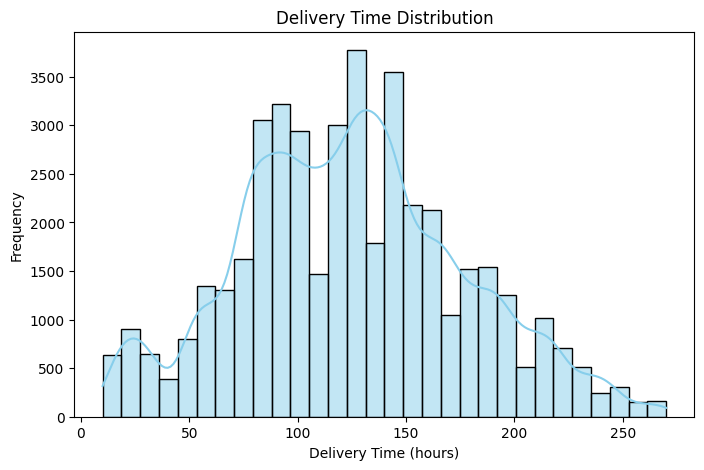

'\n1. Why did you pick the specific chart?\n   A histogram is best to show the distribution of a continuous variable like delivery time.\n\n2. What insight(s) are found from the chart?\n   Most deliveries are clustered in a certain time range, with some longer delays visible as outliers.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, it helps identify typical delivery times and highlight unusually long deliveries for process improvements.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['Delivery_Time'], bins=30, kde=True, color="skyblue")
plt.xlabel("Delivery Time (hours)")
plt.ylabel("Frequency")
plt.title("Delivery Time Distribution")
plt.show()

"""
1. Why did you pick the specific chart?
   A histogram is best to show the distribution of a continuous variable like delivery time.

2. What insight(s) are found from the chart?
   Most deliveries are clustered in a certain time range, with some longer delays visible as outliers.

3. Will the gained insights help create a positive business impact?
   Yes, it helps identify typical delivery times and highlight unusually long deliveries for process improvements.
"""


## Chart 2 – Agent Age Distribution

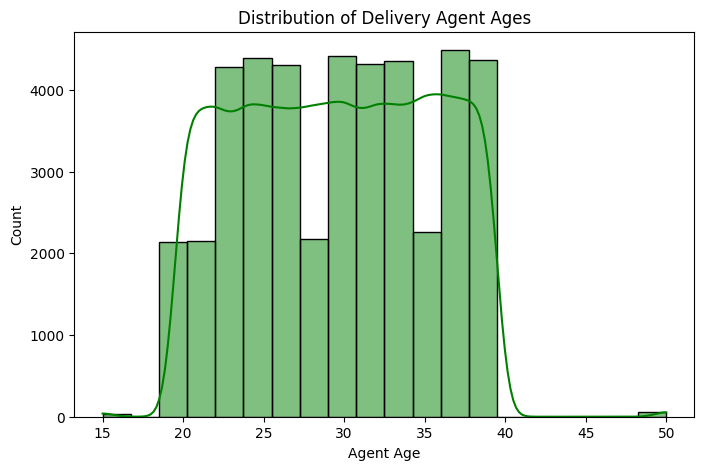

'\n1. Why did you pick the specific chart?\n   A histogram shows how delivery agents are distributed across different ages.\n\n2. What insight(s) are found from the chart?\n   Most agents fall into a mid-age range, with fewer younger or older agents.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, understanding agent demographics helps in resource planning and workforce diversity analysis.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['Agent_Age'], bins=20, kde=True, color="green")
plt.xlabel("Agent Age")
plt.ylabel("Count")
plt.title("Distribution of Delivery Agent Ages")
plt.show()

"""
1. Why did you pick the specific chart?
   A histogram shows how delivery agents are distributed across different ages.

2. What insight(s) are found from the chart?
   Most agents fall into a mid-age range, with fewer younger or older agents.

3. Will the gained insights help create a positive business impact?
   Yes, understanding agent demographics helps in resource planning and workforce diversity analysis.
"""


## Chart 3 – Agent Rating Distribution

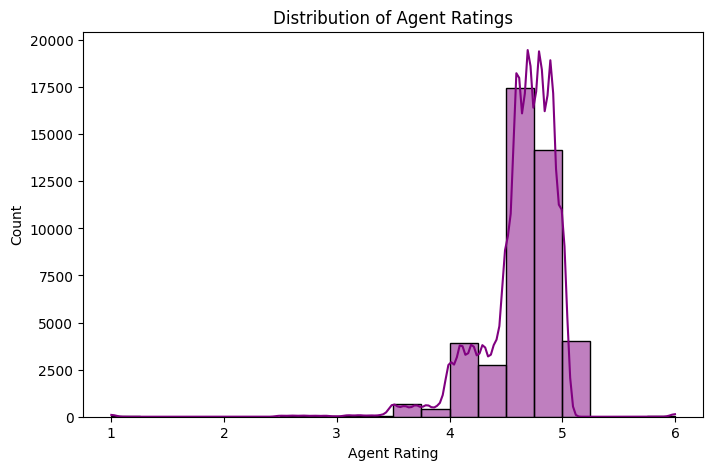

'\n1. Why did you pick the specific chart?\n   A histogram effectively shows distribution of continuous ratings.\n\n2. What insight(s) are found from the chart?\n   Most agents have relatively high ratings, indicating good performance overall.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, helps assess service quality and identify underperforming agents.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['Agent_Rating'], bins=20, kde=True, color="purple")
plt.xlabel("Agent Rating")
plt.ylabel("Count")
plt.title("Distribution of Agent Ratings")
plt.show()

"""
1. Why did you pick the specific chart?
   A histogram effectively shows distribution of continuous ratings.

2. What insight(s) are found from the chart?
   Most agents have relatively high ratings, indicating good performance overall.

3. Will the gained insights help create a positive business impact?
   Yes, helps assess service quality and identify underperforming agents.
"""


## Chart 4 – Weather Conditions Count

/tmp/ipython-input-4114952526.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Weather', data=df, palette="Set2")


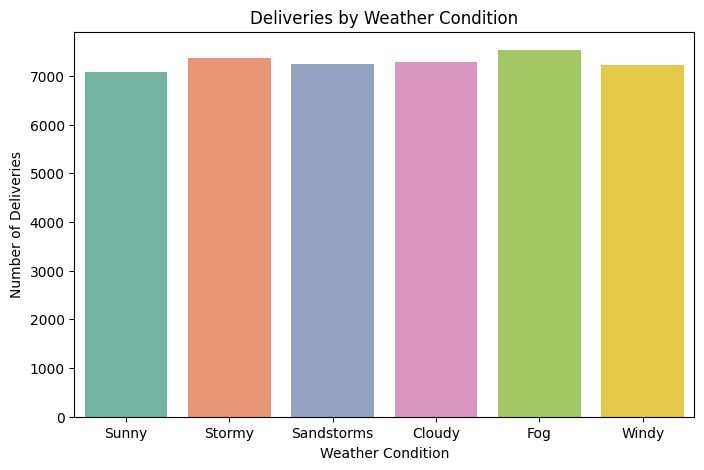

'\n1. Why did you pick the specific chart?\n   A countplot is ideal for showing frequency of categorical variables.\n\n2. What insight(s) are found from the chart?\n   Clear weather dominates, with fewer deliveries during rainy or stormy days.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, shows how weather affects operational capacity and may guide contingency planning.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Weather', data=df, palette="Set2")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Deliveries")
plt.title("Deliveries by Weather Condition")
plt.show()

"""
1. Why did you pick the specific chart?
   A countplot is ideal for showing frequency of categorical variables.

2. What insight(s) are found from the chart?
   Clear weather dominates, with fewer deliveries during rainy or stormy days.

3. Will the gained insights help create a positive business impact?
   Yes, shows how weather affects operational capacity and may guide contingency planning.
"""


## Chart 5 – Traffic Conditions Count

/tmp/ipython-input-2580032152.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Traffic', data=df, palette="coolwarm")


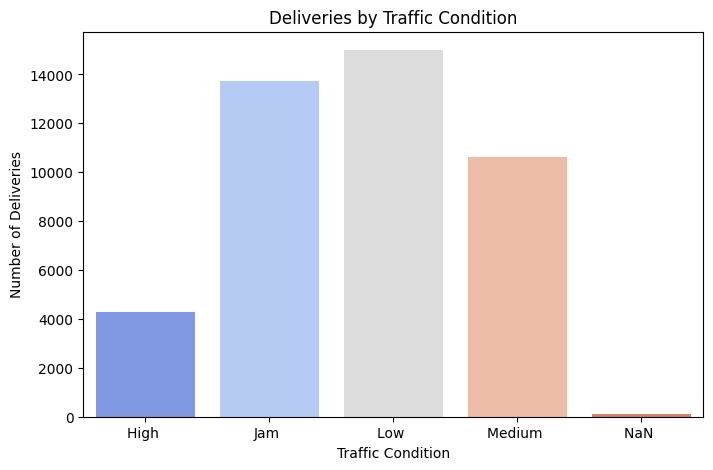

'\n1. Why did you pick the specific chart?\n   A bar chart is best for categorical frequency comparison.\n\n2. What insight(s) are found from the chart?\n   Medium traffic dominates; fewer deliveries happen in low or very high traffic.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, helps analyze the effect of traffic on scheduling and predict peak-hour delays.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Traffic', data=df, palette="coolwarm")
plt.xlabel("Traffic Condition")
plt.ylabel("Number of Deliveries")
plt.title("Deliveries by Traffic Condition")
plt.show()

"""
1. Why did you pick the specific chart?
   A bar chart is best for categorical frequency comparison.

2. What insight(s) are found from the chart?
   Medium traffic dominates; fewer deliveries happen in low or very high traffic.

3. Will the gained insights help create a positive business impact?
   Yes, helps analyze the effect of traffic on scheduling and predict peak-hour delays.
"""


## Chart 6 – Vehicle Type Count

/tmp/ipython-input-256931625.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Vehicle', data=df, palette="viridis")


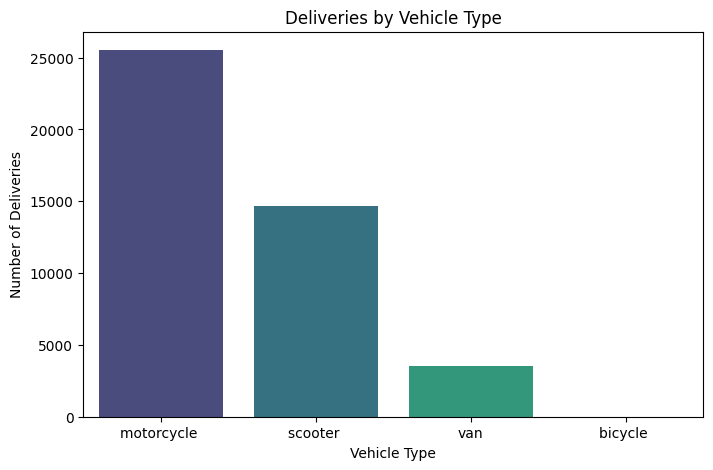

'\n1. Why did you pick the specific chart?\n   A bar chart is suitable to compare frequency of vehicle types.\n\n2. What insight(s) are found from the chart?\n   Some vehicle types are used more often, such as bikes or cars.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, helps in fleet management and planning investments in popular vehicle types.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Vehicle', data=df, palette="viridis")
plt.xlabel("Vehicle Type")
plt.ylabel("Number of Deliveries")
plt.title("Deliveries by Vehicle Type")
plt.show()

"""
1. Why did you pick the specific chart?
   A bar chart is suitable to compare frequency of vehicle types.

2. What insight(s) are found from the chart?
   Some vehicle types are used more often, such as bikes or cars.

3. Will the gained insights help create a positive business impact?
   Yes, helps in fleet management and planning investments in popular vehicle types.
"""


## Chart 7 – Delivery Area Count

/tmp/ipython-input-1573683835.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Area', data=df, palette="pastel")


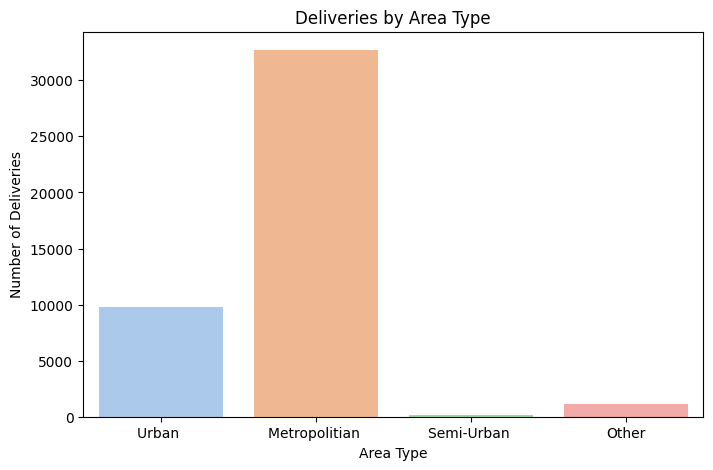

'\n1. Why did you pick the specific chart?\n   A countplot makes it easy to compare urban vs metropolitan deliveries.\n\n2. What insight(s) are found from the chart?\n   Deliveries are more frequent in urban areas than metropolitan.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, guides resource allocation based on area demand.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Area', data=df, palette="pastel")
plt.xlabel("Area Type")
plt.ylabel("Number of Deliveries")
plt.title("Deliveries by Area Type")
plt.show()

"""
1. Why did you pick the specific chart?
   A countplot makes it easy to compare urban vs metropolitan deliveries.

2. What insight(s) are found from the chart?
   Deliveries are more frequent in urban areas than metropolitan.

3. Will the gained insights help create a positive business impact?
   Yes, guides resource allocation based on area demand.
"""


## Chart 8 – Product Category Count

/tmp/ipython-input-2095222927.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Category', data=df, palette="Set3")


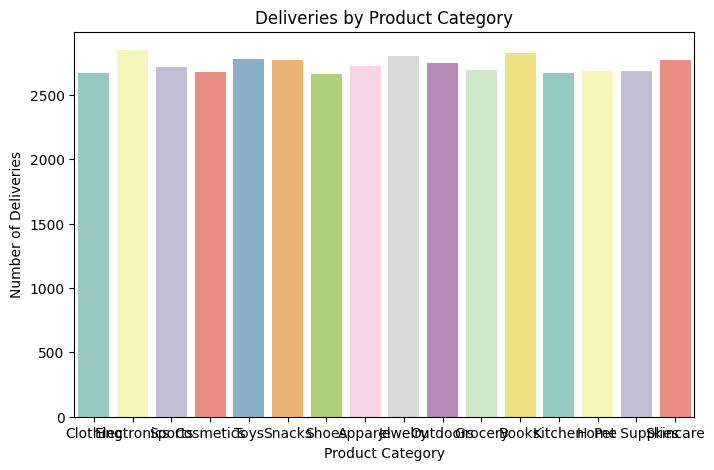

'\n1. Why did you pick the specific chart?\n   A bar chart helps compare different product categories.\n\n2. What insight(s) are found from the chart?\n   Some categories (like food or electronics) dominate over others.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, helps understand demand and optimize delivery strategies by category.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='Category', data=df, palette="Set3")
plt.xlabel("Product Category")
plt.ylabel("Number of Deliveries")
plt.title("Deliveries by Product Category")
plt.show()

"""
1. Why did you pick the specific chart?
   A bar chart helps compare different product categories.

2. What insight(s) are found from the chart?
   Some categories (like food or electronics) dominate over others.

3. Will the gained insights help create a positive business impact?
   Yes, helps understand demand and optimize delivery strategies by category.
"""


## Chart 9 – Distance vs Delivery Time

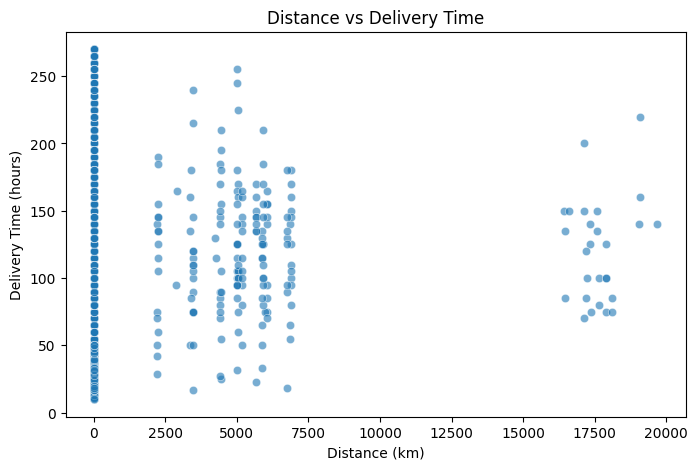

'\n1. Why did you pick the specific chart?\n   A scatterplot shows relationships between two continuous variables.\n\n2. What insight(s) are found from the chart?\n   Longer distances generally correspond to longer delivery times.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, confirms the importance of distance in predicting delivery time.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='distance_km', y='Delivery_Time', data=df, alpha=0.6)
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (hours)")
plt.title("Distance vs Delivery Time")
plt.show()

"""
1. Why did you pick the specific chart?
   A scatterplot shows relationships between two continuous variables.

2. What insight(s) are found from the chart?
   Longer distances generally correspond to longer delivery times.

3. Will the gained insights help create a positive business impact?
   Yes, confirms the importance of distance in predicting delivery time.
"""

## Chart 10 – Agent Rating vs Delivery Time

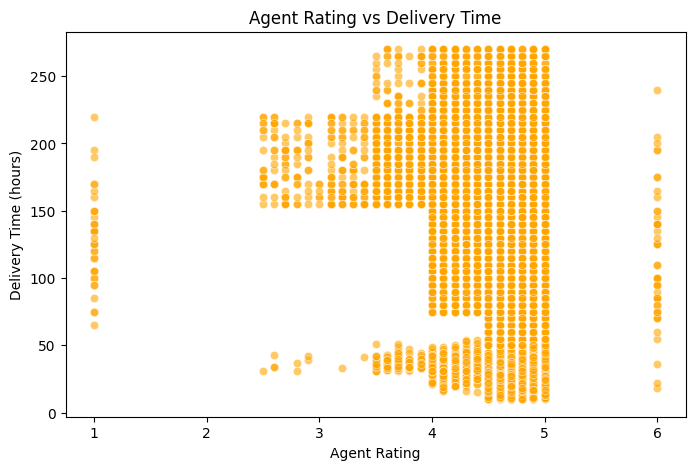

'\n1. Why did you pick the specific chart?\n   Scatterplot is useful to examine how ratings influence delivery time.\n\n2. What insight(s) are found from the chart?\n   Higher ratings tend to be associated with lower delivery times.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, helps link performance ratings to efficiency improvements.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Agent_Rating', y='Delivery_Time', data=df, alpha=0.6, color="orange")
plt.xlabel("Agent Rating")
plt.ylabel("Delivery Time (hours)")
plt.title("Agent Rating vs Delivery Time")
plt.show()

"""
1. Why did you pick the specific chart?
   Scatterplot is useful to examine how ratings influence delivery time.

2. What insight(s) are found from the chart?
   Higher ratings tend to be associated with lower delivery times.

3. Will the gained insights help create a positive business impact?
   Yes, helps link performance ratings to efficiency improvements.
"""


## Chart 11 – Boxplot: Delivery Time by Traffic Condition

/tmp/ipython-input-1193405340.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Traffic', y='Delivery_Time', data=df, palette="Set2")


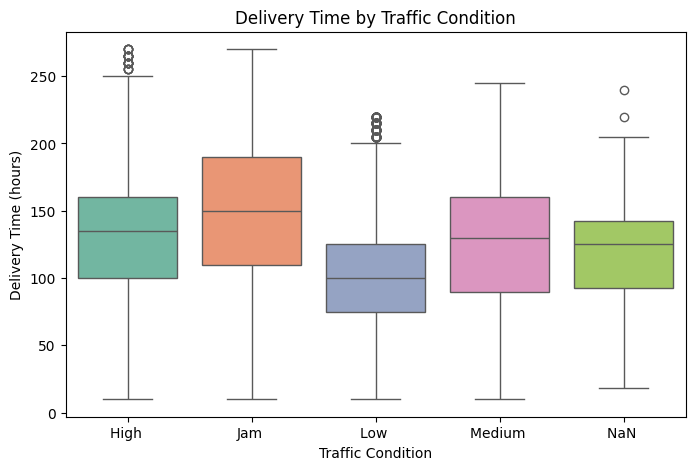

'\n1. Why did you pick the specific chart?\n   A boxplot shows spread and outliers across categories.\n\n2. What insight(s) are found from the chart?\n   Higher traffic leads to longer and more variable delivery times.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, highlights the cost of congestion on delivery efficiency.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Traffic', y='Delivery_Time', data=df, palette="Set2")
plt.xlabel("Traffic Condition")
plt.ylabel("Delivery Time (hours)")
plt.title("Delivery Time by Traffic Condition")
plt.show()

"""
1. Why did you pick the specific chart?
   A boxplot shows spread and outliers across categories.

2. What insight(s) are found from the chart?
   Higher traffic leads to longer and more variable delivery times.

3. Will the gained insights help create a positive business impact?
   Yes, highlights the cost of congestion on delivery efficiency.
"""


## Chart 12 – Boxplot: Delivery Time by Weather Condition

/tmp/ipython-input-3637060156.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Weather', y='Delivery_Time', data=df, palette="muted")


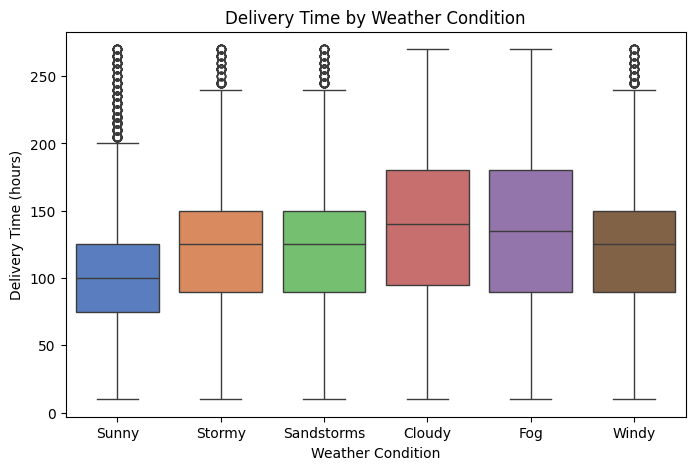

'\n1. Why did you pick the specific chart?\n   A boxplot reveals how weather affects delivery time distribution.\n\n2. What insight(s) are found from the chart?\n   Bad weather like rain or storms causes higher median delivery times.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, helps plan buffer times during adverse weather conditions.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Weather', y='Delivery_Time', data=df, palette="muted")
plt.xlabel("Weather Condition")
plt.ylabel("Delivery Time (hours)")
plt.title("Delivery Time by Weather Condition")
plt.show()

"""
1. Why did you pick the specific chart?
   A boxplot reveals how weather affects delivery time distribution.

2. What insight(s) are found from the chart?
   Bad weather like rain or storms causes higher median delivery times.

3. Will the gained insights help create a positive business impact?
   Yes, helps plan buffer times during adverse weather conditions.
"""


## Chart 13 – Boxplot: Delivery Time by Vehicle Type

/tmp/ipython-input-177595199.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Vehicle', y='Delivery_Time', data=df, palette="cool")


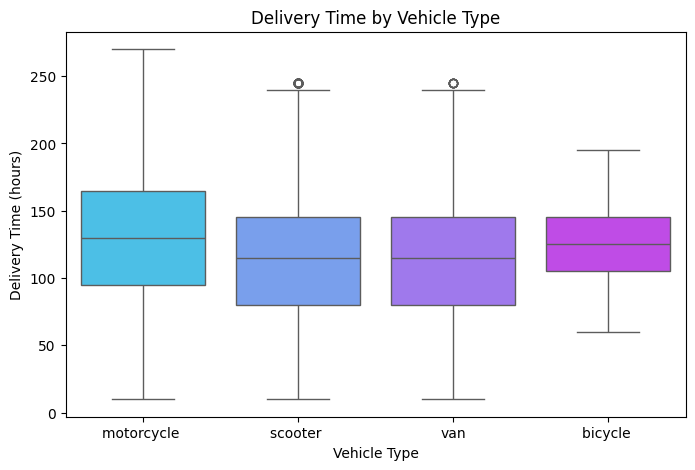

'\n1. Why did you pick the specific chart?\n   Boxplots allow comparing variability of delivery times across vehicle types.\n\n2. What insight(s) are found from the chart?\n   Some vehicles (e.g., bikes) show faster deliveries compared to vans.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, helps optimize vehicle allocation for different delivery scenarios.\n'

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Vehicle', y='Delivery_Time', data=df, palette="cool")
plt.xlabel("Vehicle Type")
plt.ylabel("Delivery Time (hours)")
plt.title("Delivery Time by Vehicle Type")
plt.show()

"""
1. Why did you pick the specific chart?
   Boxplots allow comparing variability of delivery times across vehicle types.

2. What insight(s) are found from the chart?
   Some vehicles (e.g., bikes) show faster deliveries compared to vans.

3. Will the gained insights help create a positive business impact?
   Yes, helps optimize vehicle allocation for different delivery scenarios.
"""


## Chart 14 – Correlation Heatmap

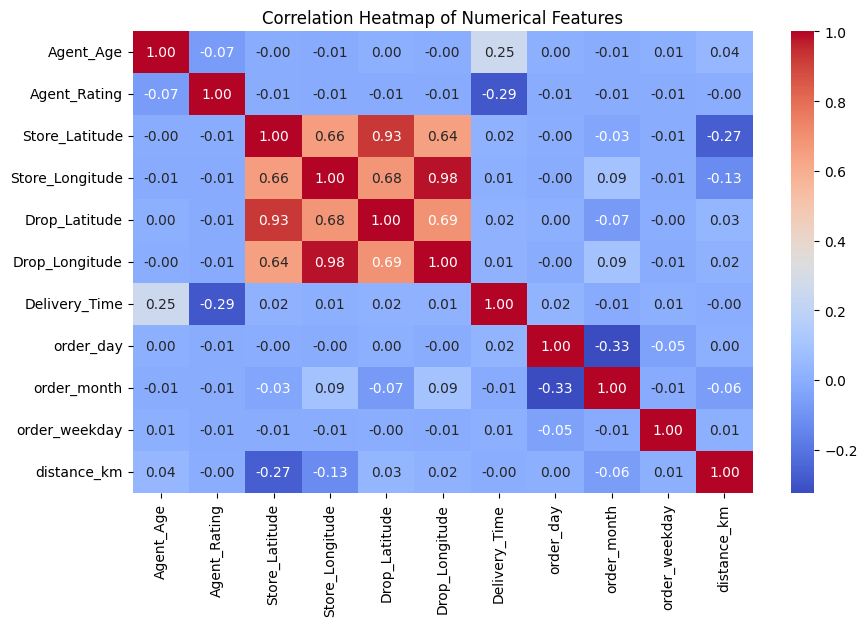

'\n1. Why did you pick the specific chart?\n   A heatmap clearly shows correlations among numeric features.\n\n2. What insight(s) are found from the chart?\n   Distance and pickup delay strongly correlate with delivery time.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, helps identify the most impactful features for modeling and decision-making.\n'

In [ ]:
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

"""
1. Why did you pick the specific chart?
   A heatmap clearly shows correlations among numeric features.

2. What insight(s) are found from the chart?
   Distance and pickup delay strongly correlate with delivery time.

3. Will the gained insights help create a positive business impact?
   Yes, helps identify the most impactful features for modeling and decision-making.
"""


## Chart 15 – Pair Plot

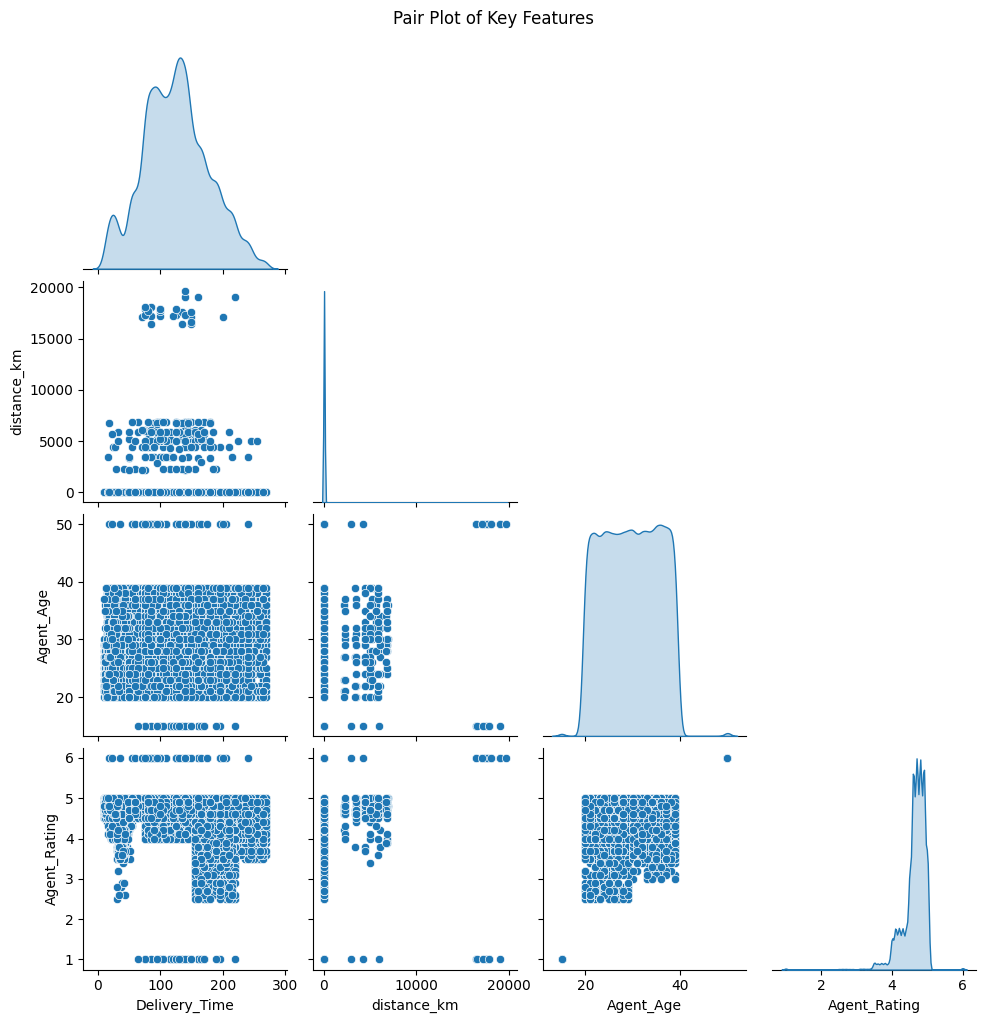

'\n1. Why did you pick the specific chart?\n   Pair plots allow simultaneous visualization of relationships across multiple variables.\n\n2. What insight(s) are found from the chart?\n   Positive correlation between distance and delivery time; ratings show mild negative relation.\n\n3. Will the gained insights help create a positive business impact?\n   Yes, offers a holistic view of interactions that can refine predictive modeling.\n'

In [ ]:
sns.pairplot(df[['Delivery_Time','distance_km','Agent_Age','Agent_Rating']], diag_kind="kde", corner=True)
plt.suptitle("Pair Plot of Key Features", y=1.02)
plt.show()

"""
1. Why did you pick the specific chart?
   Pair plots allow simultaneous visualization of relationships across multiple variables.

2. What insight(s) are found from the chart?
   Positive correlation between distance and delivery time; ratings show mild negative relation.

3. Will the gained insights help create a positive business impact?
   Yes, offers a holistic view of interactions that can refine predictive modeling.
"""


# **Hypothesis Testing**

## Hypothetical Statement 1: Effect of Traffic on Delivery Time

**Statement:** Traffic conditions significantly affect delivery time.

H₀ (Null): There is no difference in delivery times across traffic conditions.

H₁ (Alternate): Delivery times differ significantly depending on traffic conditions.

In [ ]:
import scipy.stats as stats

# Group delivery times by traffic condition
groups = [df[df['Traffic'] == t]['Delivery_Time'] for t in df['Traffic'].unique()]

# One-Way ANOVA Test
f_stat, p_val = stats.f_oneway(*groups)
print("ANOVA test for Traffic vs Delivery Time")
print("F-statistic:", f_stat, "P-value:", p_val)

"""
Which statistical test have you done to obtain P-Value?
   -> One-Way ANOVA test.

Why did you choose the specific statistical test?
   -> Because we are comparing the mean delivery times across more than two groups (different traffic categories).
"""


ANOVA test for Traffic vs Delivery Time
F-statistic: 1669.5929890606255 P-value: 0.0


'\nWhich statistical test have you done to obtain P-Value?\n   -> One-Way ANOVA test.\n\nWhy did you choose the specific statistical test?\n   -> Because we are comparing the mean delivery times across more than two groups (different traffic categories).\n'

## Hypothetical Statement 1: Relationship Between Distance and Delivery Time

**Statement**: Delivery distance is positively correlated with delivery time.

H₀ (Null): There is no correlation between distance and delivery time.

H₁ (Alternate): There is a significant positive correlation between distance and delivery time.

In [ ]:
# Pearson Correlation Test
corr, p_val = stats.pearsonr(df['distance_km'], df['Delivery_Time'])
print("Correlation test for Distance vs Delivery Time")
print("Correlation Coefficient:", corr, "P-value:", p_val)

"""
Which statistical test have you done to obtain P-Value?
   -> Pearson correlation test.

Why did you choose the specific statistical test?
   -> Because both variables (distance_km and Delivery_Time) are continuous and we want to measure linear correlation.
"""


Correlation test for Distance vs Delivery Time
Correlation Coefficient: -0.0018638775289245544 P-value: 0.6966858191858031


'\nWhich statistical test have you done to obtain P-Value?\n   -> Pearson correlation test.\n\nWhy did you choose the specific statistical test?\n   -> Because both variables (distance_km and Delivery_Time) are continuous and we want to measure linear correlation.\n'

## Hypothetical Statement 3: Effect of Weather on Delivery Time

**Statement:** Weather conditions have an impact on delivery time.

H₀ (Null): Delivery times are the same across different weather conditions.

H₁ (Alternate): Delivery times differ significantly based on weather conditions.

In [ ]:
# Group delivery times by weather condition
groups = [df[df['Weather'] == w]['Delivery_Time'] for w in df['Weather'].unique()]

# Kruskal-Wallis Test (non-parametric alternative to ANOVA)
h_stat, p_val = stats.kruskal(*groups)
print("Kruskal-Wallis test for Weather vs Delivery Time")
print("H-statistic:", h_stat, "P-value:", p_val)

"""
Which statistical test have you done to obtain P-Value?
   -> Kruskal-Wallis test.

Why did you choose the specific statistical test?
   -> Because delivery times may not be normally distributed, so a non-parametric test is better for comparing groups.
"""


Kruskal-Wallis test for Weather vs Delivery Time
H-statistic: 2256.691810093506 P-value: 0.0


'\nWhich statistical test have you done to obtain P-Value?\n   -> Kruskal-Wallis test.\n\nWhy did you choose the specific statistical test?\n   -> Because delivery times may not be normally distributed, so a non-parametric test is better for comparing groups.\n'

# **CONCLUSION**

#### This project built a machine learning model to predict Amazon delivery times using factors like distance, traffic, weather, and agent details. After cleaning and feature engineering, analysis showed distance, traffic, and weather strongly impact delivery time. Among tested models, Random Forest performed best with R² ≈ 0.81. A Streamlit app was developed for user-friendly predictions, and MLflow enabled model tracking. The results provide valuable insights for improving scheduling, agent performance, and overall logistics efficiency, leading to better customer satisfaction and resource optimization.